## Import Libraries

In [1]:
import nltk
import tensorflow as tf
import keras
from gensim.models import Word2Vec
import multiprocessing
import os
from keras.initializers import Constant
import matplotlib.pyplot as plt
import keras.backend as K
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping

Using TensorFlow backend.
C:\Program Files\Python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Importing Data from Penn Treebank Dataset

In [2]:
tagged_sentences = nltk.corpus.treebank.tagged_sents()
 
print(tagged_sentences[0])
print("Tagged sentences: ", len(tagged_sentences))
print("Tagged words:", len(nltk.corpus.treebank.tagged_words()))

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]
Tagged sentences:  3914
Tagged words: 100676


### Pre-processing of Data

In [3]:
import numpy as np
 
sentences, sentence_tags =[], [] 
for tagged_sentence in tagged_sentences:
    sentence, tags = zip(*tagged_sentence)
    sentences.append(sentence)
    sentence_tags.append(tags)
print(sentences[0])
print(sentence_tags[0])
# ['Lorillard' 'Inc.' ',' 'the' 'unit' 'of' 'New' 'York-based' 'Loews'
#  'Corp.' 'that' '*T*-2' 'makes' 'Kent' 'cigarettes' ',' 'stopped' 'using'
#  'crocidolite' 'in' 'its' 'Micronite' 'cigarette' 'filters' 'in' '1956'
# '.']
# ['NNP' 'NNP' ',' 'DT' 'NN' 'IN' 'JJ' 'JJ' 'NNP' 'NNP' 'WDT' '-NONE-' 'VBZ'
#  'NNP' 'NNS' ',' 'VBD' 'VBG' 'NN' 'IN' 'PRP$' 'NN' 'NN' 'NNS' 'IN' 'CD'
#  '.']]

('Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.')
('NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.')


### Building Dictionary, Adding Padding and Out of Vocabulary

In [4]:
from sklearn.model_selection import train_test_split
 
train_sentences, test_sentences, train_tags, test_tags = train_test_split(sentences, sentence_tags, test_size=0.2)

words, tags = set([]), set([])
 
for s in train_sentences:
    for w in s:
        words.add(w.lower())

for ts in train_tags:
    for t in ts:
        tags.add(t)

word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0  # The special value used for padding
word2index['-OOV-'] = 1  # The special value used for OOVs
 
tag2index = {t: i + 1 for i, t in enumerate(list(tags))}
tag2index['-PAD-'] = 0  # The special value used to padding

## If you want to use Word2Vec

### Model Parameters for Word2Vec

In [5]:
#Declare Model Parameters
cbow = 0
skipgram = 1
EMB_DIM = 300 #more dimensions, more computationally expensive to train
min_word_count = 1
workers = multiprocessing.cpu_count() #based on computer cpu count
context_size = 7
downsampling = 1e-3
learning_rate = 0.025 #initial learning rate
min_learning_rate = 0.025 #fixated learning rate
num_epoch = 15

### Initialize and Train Word2Vec

In [6]:
w2v = Word2Vec(
    sg = skipgram,
    hs = 1, #hierarchical softmax
    size = EMB_DIM,
    min_count = min_word_count, 
    workers = workers,
    window = context_size, 
    sample = downsampling, 
    alpha = learning_rate, 
    min_alpha = min_learning_rate
)
print('Vocabulary size: %d' % len(words))
w2v.build_vocab(train_sentences)
w2v.train(train_sentences,epochs=10,total_examples=w2v.corpus_count)
words = list(w2v.wv.vocab)
# save model in ASCII (word2vec) format
filename = 'embedding_word2vec.txt'
w2v.wv.save_word2vec_format(filename, binary=False)

Vocabulary size: 10106


### Create Embedding Matrix

In [7]:
embeddings_index={}
f=open(os.path.join('','embedding_word2vec.txt '),encoding="utf-8")
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:])
    embeddings_index[word]=coefs
f.close()

In [8]:
train_sentences_X, test_sentences_X, train_tags_y, test_tags_y = [], [], [], []

num_words=len(word2index)+1
embedding_matrix=np.zeros((num_words,EMB_DIM))
print(word2index)
for word,i in word2index.items():
    if i>num_words:
        continue
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

{'reader': 2, 'protest': 3, 'carillons': 4, 'trader': 5, 'sympathetic': 6, 'upsetting': 7, 'scams': 8, 'karns': 9, 'infringed': 10, '*rnr*-2': 11, 'ogilvy': 12, 'spin-off': 13, 'pressured': 14, 'ft': 15, 'visit': 16, 'lines': 17, 'seconds': 18, 'limitation': 19, 'apology': 20, 'relocate': 21, 'demonstrates': 22, 'current': 23, '86.12': 24, 'defended': 25, '100,980': 26, 'funding': 27, 'criminal': 28, 'bloc': 29, 'outlay': 30, 'reversed': 31, 'destination': 32, 'violations': 33, 'determined': 34, 'democratic': 35, 'nearby': 36, 'strategic': 37, 'defendants': 38, '45': 39, 'teach': 40, '2019': 41, 'high-quality': 42, 'scotia': 43, 'exchange': 44, 'arising': 45, 'blindfold': 46, '140': 47, 'framers': 48, 'g.': 49, 'mushy': 50, 'failure': 51, 'cattle': 52, 'drastic': 53, 'u.s.-japan': 54, 'thomas': 55, 'low-cost': 56, 'approval': 57, 'effort': 58, 'scripps': 59, 'van': 60, 'expected': 61, 'injecting': 62, 'prices': 63, 'la.': 64, 'sound': 65, 'pattenden': 66, 'purepac': 67, '274': 68, 'exe

### Convert Sentences and Tags to Indexes

In [9]:
for s in train_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    train_sentences_X.append(s_int)

for s in test_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    test_sentences_X.append(s_int)

for s in train_tags:
    train_tags_y.append([tag2index[t] for t in s])

for s in test_tags:
    test_tags_y.append([tag2index[t] for t in s])

print(train_sentences_X[0])
print(test_sentences_X[0])
print(train_tags_y[0])
print(test_tags_y[0])

[1958, 7638, 3446, 9515, 1543, 5470, 2562, 2344, 8808, 7804, 2539, 9515, 6924, 7623, 2290, 1958, 4855, 9515, 5144, 264, 6401, 2344, 3564, 7804, 2539, 2278]
[2530, 4098, 6613, 6018, 5404, 3821, 3594, 2806, 3918, 2254, 9515, 4094, 9515, 4405, 3918, 4684, 9515, 802, 9515, 8776, 1958, 2254, 706, 8650, 4534, 3349, 1409, 4855, 2890, 1761, 9515, 8682, 4976, 2785, 9884, 986, 4405, 5894, 2993, 9855, 6369, 2278]
[27, 8, 31, 32, 34, 8, 2, 43, 5, 5, 9, 32, 12, 5, 14, 27, 8, 32, 37, 8, 37, 43, 5, 5, 9, 16]
[27, 5, 34, 8, 8, 44, 34, 37, 17, 5, 32, 5, 32, 39, 17, 5, 32, 5, 32, 37, 27, 5, 8, 8, 37, 27, 34, 8, 8, 17, 32, 30, 14, 15, 21, 9, 39, 41, 21, 9, 9, 16]


## Paddings

In [10]:
MAX_LENGTH = len(max(train_sentences_X, key=len))
print(MAX_LENGTH)  # 271

from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(train_sentences_X, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(test_sentences_X, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')
 
print(train_sentences_X[0])
print(train_tags_y[0])

271
[1958 7638 3446 9515 1543 5470 2562 2344 8808 7804 2539 9515 6924 7623
 2290 1958 4855 9515 5144  264 6401 2344 3564 7804 2539 2278    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  

## Create your Keras Model

In [11]:
from keras.models import Sequential
from keras.layers import Dense, CuDNNLSTM,LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation,Dropout
from keras.optimizers import Adam
from keras.models import load_model

model = Sequential()
#embedding_layer=Embedding(num_words,EMB_DIM,embeddings_initializer=Constant(embedding_matrix),input_length=MAX_LENGTH,trainable=True,mask_zero=True)
embedding_layer=Embedding(num_words, 300,mask_zero=True)
model.add(InputLayer(input_shape=(MAX_LENGTH, )))
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128, return_sequences=True,activation="tanh",recurrent_dropout=0.2)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, return_sequences=True,activation="tanh",recurrent_dropout=0.2)))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(len(tag2index),activation="relu")))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.01),    
              metrics=["accuracy"])
#plot_model(model, to_file='model.png')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 271, 300)          3032700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 271, 256)          439296    
_________________________________________________________________
dropout_1 (Dropout)          (None, 271, 256)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 271, 256)          394240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 271, 256)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 271, 47)           12079     
_________________________________________________________________
activation_1 (Activation)    (None, 271, 47)           0         
Total para

## One-Hot Encoding

In [12]:
def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)


cat_train_tags_y = to_categorical(train_tags_y, len(tag2index))
print(cat_train_tags_y[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


## Training the Model

In [13]:
es = EarlyStopping(monitor='val_acc', mode='max',verbose=1,patience=3,min_delta=0)
history=model.fit(train_sentences_X, to_categorical(train_tags_y, len(tag2index)),batch_size=256, callbacks=[es], epochs=30,validation_data=(test_sentences_X, to_categorical(test_tags_y, len(tag2index))))

Train on 3131 samples, validate on 783 samples
Epoch 1/30
3131/3131 [==============================] - 116s 37ms/step - loss: 3.2749 - acc: 0.1617 - val_loss: 2.2302 - val_acc: 0.4223
Epoch 2/30
3131/3131 [==============================] - 70s 22ms/step - loss: 1.4690 - acc: 0.6157 - val_loss: 0.6416 - val_acc: 0.8458
Epoch 3/30
3131/3131 [==============================] - 69s 22ms/step - loss: 0.4419 - acc: 0.8919 - val_loss: 0.3687 - val_acc: 0.9089
Epoch 4/30
3131/3131 [==============================] - 72s 23ms/step - loss: 0.2044 - acc: 0.9481 - val_loss: 0.3068 - val_acc: 0.9239
Epoch 5/30
3131/3131 [==============================] - 84s 27ms/step - loss: 0.1278 - acc: 0.9657 - val_loss: 0.2939 - val_acc: 0.9310
Epoch 6/30
3131/3131 [==============================] - 94s 30ms/step - loss: 0.0918 - acc: 0.9742 - val_loss: 0.2943 - val_acc: 0.9308
Epoch 7/30
3131/3131 [==============================] - 69s 22ms/step - loss: 0.0750 - acc: 0.9783 - val_loss: 0.3076 - val_acc: 0.9326


## Accompanying Visualizations

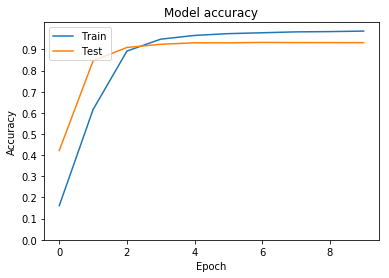

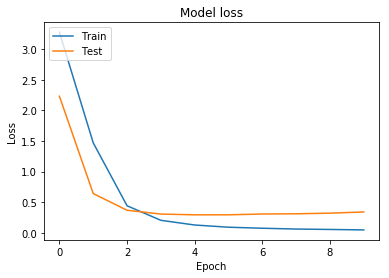

In [14]:
# Plot training & validation accuracy values
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.yticks(np.arange(0,1,step=0.1))
plt.savefig("fake_acc.png")

plt.figure( )
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("loss.png")

## Model Evaluation

In [15]:
scores = model.evaluate(test_sentences_X, to_categorical(test_tags_y, len(tag2index)))
print(model.metrics_names)   # acc: 99.09751977804825   
print(scores)   # acc: 99.09751977804825
model.save("model.h5")

783/783 [==============================] - 23s 30ms/step
['loss', 'acc']
[0.34326003786856796, 0.9311845263758839]


## Testing the Model

In [17]:
test_samples = [
    "Mr. X will run for President".split(),
    "There is a criminal on the run".split(),
]
 
# [['running', 'is', 'very', 'important', 'for', 'me', '.'], ['I', 'was', 'running', 'every', 'day', 'for', 'a', 'month', '.']]
 
test_samples_X = []
for s in test_samples:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
    test_samples_X.append(s_int)

test_samples_X = pad_sequences(test_samples_X, maxlen=MAX_LENGTH, padding='post')


predictions = model.predict(test_samples_X)
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            token_sequence.append(index[np.argmax(categorical)])
 
        token_sequences.append(token_sequence)
 
    return token_sequences


final_pred=logits_to_tokens(predictions, {i: t for t, i in tag2index.items()})
for x in range(len(test_samples)):
    print(test_samples[x])
    print(final_pred[x][0:len(test_samples[x])])

['Mr.', 'X', 'will', 'run', 'for', 'President']
['NNP', 'NNP', 'MD', 'VB', 'IN', 'NN']
['There', 'is', 'a', 'criminal', 'on', 'the', 'run']
['EX', 'VBZ', 'DT', 'NN', 'IN', 'DT', 'NN']
['Running', 'is', 'a', 'good', 'exercise']
['VBG', 'VBZ', 'DT', 'JJ', 'VB']
['I', 'am', 'running']
['PRP', 'VBP', 'VBG']
